Aim:
- Assignment for the NLP module

Created: 10 June 2022

## Libraries

NLTK

In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Harris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Harris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

Zeugma, Theano

In [3]:
# from zeugma.embeddings import EmbeddingTransformer

Other modules

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from pprint import pprint


import warnings; warnings.simplefilter('ignore')

## sklearn also has some nice funtions for representations

# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Classifiers
# from sklearn.linear_model import SGDClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import LinearSVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC


# ## and for evaluation
# from sklearn.pipeline import Pipeline
# from sklearn import metrics
# from sklearn.model_selection import cross_validate
# from sklearn.model_selection import cross_val_score

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from pathlib import Path

proj_dir = Path('.')/'..'/'..'
source_data_dir = proj_dir/'data'/'source'
clean_data_dir  = proj_dir/'data'/'clean'

custom module

In [7]:
import preprocessing

essential modules 

In [36]:
import json
from datetime import datetime
from pprint import pprint
import seaborn as sns

# 0. Process source files

In [35]:
preprocessing.process_source_files(input_dir = source_data_dir/'pubmed', output_dir = clean_data_dir/'pubmed')

Read 30135 lines from ..\..\data\source\pubmed\test.txt
Wrote 30135 lines to ..\..\data\clean\pubmed\test_processed.txt
Read 180040 lines from ..\..\data\source\pubmed\train.txt
Wrote 180040 lines to ..\..\data\clean\pubmed\train_processed.txt
Read 30212 lines from ..\..\data\source\pubmed\dev.txt
Wrote 30212 lines to ..\..\data\clean\pubmed\dev_processed.txt


# 1. Import data

In [10]:
train, _, _ = preprocessing.import_processed_files(dir=clean_data_dir/'pubmed')

In [21]:
pmid_select = train['pmid'].unique().tolist()[0:2]
exp = train.query('pmid in @pmid_select')

In [24]:
exp = preprocessing.label_sentence_index(exp)
exp['label_prev'] = exp.groupby('pmid')['label'].shift(1)
exp['label_prev'] = exp['label_prev'].fillna('FIRST', inplace=False)
exp = exp.set_index(['pmid', 'sent_index'], inplace=False)
exp

['To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .', 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .', 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .', 'Pain was assessed using the visual analog pain scale ( 0-100 mm ) .', 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .', 'Serum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .', 'There was a cli

# Rule-based heuristic

1. Are there any unique tokens that exist in certain sections?

In [195]:
sections_sorted = ['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS']
df = train.copy()

In [31]:
with open('rule_based_regex_dict.json', 'r') as fp:
    regex_dict = json.load(fp)

In [34]:
pprint(regex_dict)

{'CONCLUSIONS': ['findings',
                 '(indicate|indicates|indicating) that ',
                 '(suggest|suggests|suggesting) that',
                 '(do|does) not support',
                 '(confirm|confirms|confirming) that',
                 '(support|supports|supporting) that',
                 'clinicaltrials.gov',
                 'NCT\\d+'],
 'METHODS': ['(randomized|randomised|randomization|randomisation)',
             '(single-blinded|double-blinded|single-blind|double-blind|patient-blinded)',
             '(primary|secondary) (outcome|outcomes)',
             'recruited|enrolled',
             'administered',
             '(was|were) '
             '(assigned|masked|randomized|randomised|analysed|analyzed|used '
             'to|followed-up|followed '
             'up|randomly|provided|given|treated|performed|carried out)',
             '(subjects|participants) received',
             'underwent',
             'statistically significant',
             'prospective

In [ ]:
# only update certain flags to speed up runtime
updated = ('METHODS', )

for i, (section, regexes) in enumerate(regex_dict.items()):
    if section in updated:
        print(section)
        for j, regex in enumerate(regexes):
            colname = 'flag' + '_' + section + '_' + str(j)
            print(f'{colname:<20} {regex}')
            df[colname] = df['txt'].str.contains(regex, case=False)
    
for section in regex_dict.keys():
    colname_regex = 'flag_' + section + '_*'
    new_col_name = 'any_flag_' + section
    df[new_col_name] = df.filter(regex=colname_regex).any(axis=1)

df['no_flag'] = ~df.filter(regex='any_flag_*').any(axis=1)

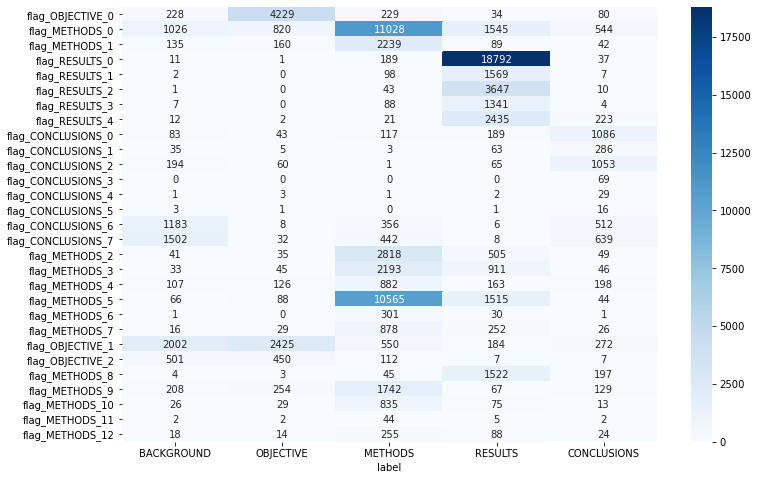

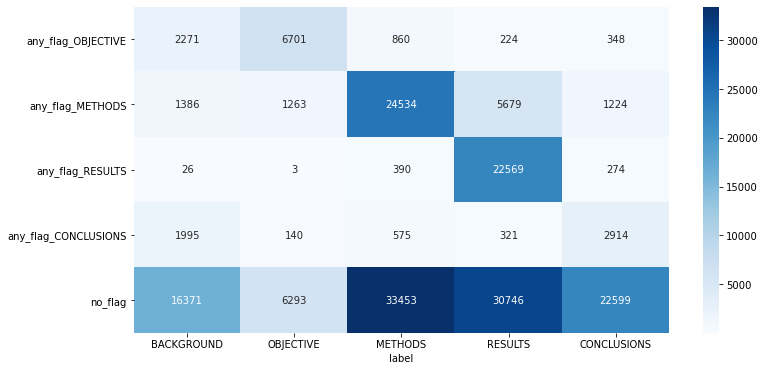

In [257]:
### show individual flags
cols = [col for col in df.columns if col.startswith('flag_')]
output = df.groupby('label')[cols].agg('sum').T
output = output[sections_sorted]

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(output, annot=True, fmt='g', cmap='Blues', ax=ax);

### show flags combined, positive when >=1 flag is positive
# not exactly a heatmap, the `combined` flag is not exclusive
cols = ['any_flag_' + section for section in regex_dict.keys()]
cols = cols + ['no_flag']
output2 = df.groupby('label')[cols].agg('sum').T
output2 = output2[sections_sorted]

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(output2, annot=True, fmt='g', cmap='Blues', ax=ax);

In [259]:
# QUERY for a text excerpt and flag
df.loc[df['txt'].str.contains('The bolus technique was performed'), 'flag_METHODS_5']

NaN    True
Name: flag_METHODS_5, dtype: bool

In [261]:
df.query('label == "RESULTS" & any_flag_RESULTS == False')['txt'].sample(20).tolist()

['At week 12 the mean ( SE ) baseline adjusted decrease from baseline in ADAS cog for PF-04447943-treated patients was -1.91 ( 0.54 ) .',
 'The average sonication time to reach massive gray-scale changes was significantly shorter in the group receiving SonoVue than the group without SonoVue .',
 'Adverse events in the first 12 weeks of treatment led to discontinuation of simeprevir in two ( < 1 % ) patients and discontinuation of placebo in one patient ( < 1 % ) ; fatigue ( 106 [ 40 % ] vs 49 [ 38 % ] patients , respectively ) and headache ( 81 [ 31 % ] vs 48 [ 37 % ] , respectively ) were the most common adverse events .',
 'A simplified score , including age , systolic blood pressure , sodium , blood urea nitrogen , and dyspnea at rest , discriminated 30-day mortality risk from 0.5 % ( score 0 ) to 53 % ( score 10 ) .',
 'One complication , perioperative anaemia requiring transfusion , occurred during the study .',
 'The average materials appeal score was high , with a mean of 3.6 on

In [249]:
train.loc[train['txt'].str.contains('The bolus technique was performed '), 'txt'].str.contains('(was|were) (assigned|masked|randomized|randomised|analysed|analyzed|used to|followed-up|followed up|randomly|provided|given|treated|performed)', case=False)

NaN    True
Name: txt, dtype: bool

In [208]:
pd.crosstab(index=df['txt'].str.contains('will be'), columns=df['label'])

label,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS
txt,,,,,
False,21632,26947,57460,13824,57916
True,95,221,1893,15,37


### Missed section ...
- https://europepmc.org/article/med/25854019 